# Meteorite Landings Per Country Using Geopandas

Author: **Marcin Sikorski**<br>
Date: April, 2023

This notebook contains a simple geospatial analysis with the use of <code>GeoPandas</code> package. Unlike other packages, this one allows the developer to work directly on SHP or GeoJSON data and perform basic geospatial operations. Plots and maps were generated with <code>cartopy</code> to preserve the mapping properties. The main results are: a worldwide choropleth of meteorite landings and more detailed analysis for a chosen country.

**Report Content:**
1. Loading and Cleaning Meteorite Data<br>
2. Loading Geographic Datasets<br>
3. Worldwide Landings With Choropleth Map<br>
4. Landings For Czech Republic<br>
5. Conclusions<br>
6. Bonus: Meteorite Landings by Discovery Type

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

### 1. Loading and Cleaning Meteorite Data

We will load data from CSV file into one dataframe using <code>pandas</code> and do preliminary data processing.

In [2]:
# loading meteorite data into dataframe
def load_meteorites():
    dataframe = pd.read_csv('meteorite-landings.csv', header=0)

    # 1. drop columns from dataframe
    dataframe = dataframe.drop(columns=['nametype', 'GeoLocation'])
    
    # 2. rename columns using dictionary
    dataframe.rename(columns={'recclass': 'class'}, inplace=True)
    
    # 3. convert gr's into kg's
    dataframe['mass'] = dataframe['mass'] / 1000
    
    # 4. convert floats into ints
    # in case 'year' column has blank values
    dataframe['year'] = dataframe['year'].fillna(value=0)
    dataframe['year'] = dataframe['year'].astype(int)
    
    return dataframe

df = load_meteorites()
df.head()

,name,id,class,mass,fall,year,reclat,reclong
0,Aachen,1,L5,0.021,Fell,1880,50.77500,6.08333
1,Aarhus,2,H6,0.720,Fell,1951,56.18333,10.23333
2,Abee,6,EH4,107.000,Fell,1952,54.21667,-113.00000
3,Acapulco,10,Acapulcoite,1.914,Fell,1976,16.88333,-99.90000
4,Achiras,370,L6,0.780,Fell,1902,-33.16667,-64.95000


At this stage, we will provide the same corrections made in previous [notebook](https://github.com/msikorski93/Meteorite-Landings/blob/main/meteorites_landings.ipynb) and work on meteorites after year 1800.

In [3]:
# further adjustments in dataframe
def correct_data():
    global df
    # 1. extract indexes for these rows and drop
    indexes = df.query('(reclat == 0 & reclong == 0) | (reclat.isnull() & reclong.isnull())').index
    df = df.drop(indexes)
    
    # 2. correct longitude for row 22946
    df.at[22946, 'reclong'] = 360 - 354.47333
    
    # 3. drop Yamato rows
    indexes = df.query('reclat == 0 & reclong == 35.66667').index
    df = df.drop(indexes)
    
    # 4. drop Österplana rows
    for i in range(31013, 31077):
        df = df.drop(axis=0, index=i)
        
    # 5. filter out new rows by year
    df = df.query('year > 1799 & year < 2014')
    
correct_data()

### 2. Loading Geographic Datasets

The <code>GeoPandas</code> library contains a default, low resolution shapefile which will be loaded into a new geospatial dataset.

In [4]:
# loading border data into geodataframe
def load_world():
    geodataframe = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # 1. drop useless columns from dataframe
    geodataframe = geodataframe.drop(columns=['pop_est', 'gdp_md_est'])
    
    # 2. rename columns using dictionary
    geodataframe.rename(columns={'name': 'country'}, inplace=True)
    
    return geodataframe

gdf_world = load_world()
gdf_world.head()

,continent,country,iso_a3,geometry
0,Oceania,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Africa,Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Africa,W. Sahara,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,North America,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [5]:
# print geodataframe's EPGS
gdf_world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

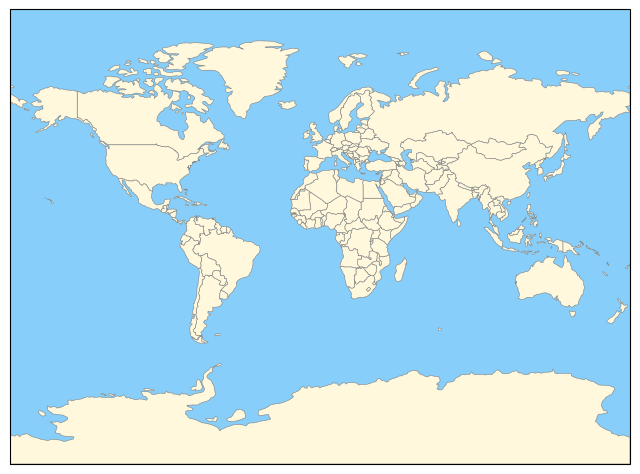

In [6]:
# overview world map
def plot_world():
    # output projection
    proj = ccrs.Miller(central_longitude=0)
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': proj})
    
    # re-project geometry to another CRS
    df_proj = gdf_world.to_crs(proj.proj4_init)
    
    # add map features
    earth = 'cornsilk'
    water = 'lightskyblue'
    ax.set_facecolor(water)
    
    # plot geodataframe with countries
    ax.add_geometries(df_proj['geometry'], crs=proj, facecolor=earth, edgecolor='grey', linewidth=0.4)
    plt.show()
    
plot_world()

The world data looks properly imported. We will convert the meteorites dataframe into a geographic dataset by creating a geometry column with points. We will assign the same coordinate reference system (EPSG code) to avoid spatial distortion.

In [7]:
# create geodataframe for meteorites
def geodataframe_meteorites():
    # create new geometry column from lat & long columns
    geodataframe = gpd.GeoDataFrame(data=df, crs=None, geometry=gpd.points_from_xy(df['reclong'], df['reclat']))
    
    # assign WGS 84 CRS to meteorite data
    geodataframe.crs = 'EPSG:4326'
    
    return geodataframe

gdf = geodataframe_meteorites()
gdf.head()

,name,id,class,mass,fall,year,reclat,reclong,geometry
0,Aachen,1,L5,0.021,Fell,1880,50.77500,6.08333,POINT (6.08333 50.77500)
1,Aarhus,2,H6,0.720,Fell,1951,56.18333,10.23333,POINT (10.23333 56.18333)
2,Abee,6,EH4,107.000,Fell,1952,54.21667,-113.00000,POINT (-113.00000 54.21667)
3,Acapulco,10,Acapulcoite,1.914,Fell,1976,16.88333,-99.90000,POINT (-99.90000 16.88333)
4,Achiras,370,L6,0.780,Fell,1902,-33.16667,-64.95000,POINT (-64.95000 -33.16667)


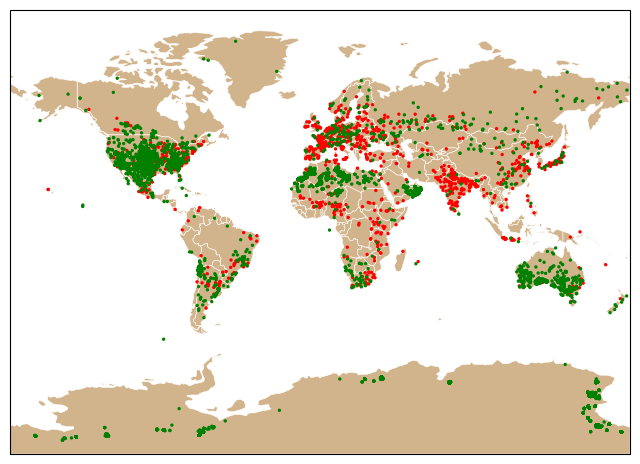

In [8]:
# worldwide scatter plot (by fell/found)
def scatter_plot():
    # output projection
    proj = ccrs.Miller(central_longitude=0)
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': proj})
    
    # re-project objects to another CRS
    count_proj = gdf_world.to_crs(proj.proj4_init)
    meteo_proj = gdf.to_crs(proj.proj4_init)
    
    # color function categorizing points by 'fall'
    def marker_color(fall):
        if fall == 'Fell':
            return 'red'
        elif fall == 'Found':
            return 'green'
        else:
            return 'blue'
    
    # create new color list
    color_list = [marker_color(discovery_type) for discovery_type in gdf['fall']]
    
    # add map features
    earth = 'tan'
    water = 'white'
    ax.set_facecolor(water)
    
    # plot geodataframe with countries
    basemap = count_proj.plot(ax=ax, color=earth, edgecolor='white', linewidth=0.4)
    meteo_proj.plot(ax=basemap, marker='o', color=color_list, markersize=2)
    plt.show()

scatter_plot()

### 3. Worldwide Landings With Choropleth Map

Using two geographic datasets we can perform spatial analysis by investigating spatial relations. We will examine how many meteorites fell per country and visualize the results with a choropleth. Some common spatial topological relationships include:

<img src=https://www.e-education.psu.edu/maps/sites/www.e-education.psu.edu.maps/files/Images/L2_Figure6a.jpg width='200'>
<center>Source: https://www.e-education.psu.edu/maps/l2_p5.html</center>

First, we will perform a spatial join to assign country per meteorite. Next, a new dataframe with count aggregation for each country will be generated. This dataframe will be then left joined to the world dataset. The results of these operations will be presented with a choropleth.

In [9]:
# generate new dataframe for choropleth map
def choropleth_dataframe():
    # 1. spatial join: points (meteorites) contained in each polygon (country)
    gdf_countries = gpd.sjoin(left_df=gdf_world, right_df=gdf, how='right', predicate='contains')
    
    # 2. dataframe with meteorite counts per country
    gdf_count = gdf_countries.groupby('country')[['id']].count().reset_index()
    gdf_count.rename(columns={'id': 'meteorite_count'}, inplace=True)
    
    # 3. join dataframes
    countries_count = pd.merge(left=gdf_world, right=gdf_count, on='country', how='left')
    # fill NaN values in 'meteorite_count' with zeros
    countries_count.fillna(value=0, inplace=True)
    
    return countries_count

countries_count = choropleth_dataframe()

# display top 5 countries with highest number of meteorites
countries_count.sort_values(by='meteorite_count', ascending=False).head(5)

,continent,country,iso_a3,geometry,meteorite_count
159,Antarctica,Antarctica,ATA,"MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...",22099.0
88,Asia,Oman,OMN,"MULTIPOLYGON (((55.20834 22.70833, 55.23449 23...",2991.0
4,North America,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",1653.0
164,Africa,Libya,LBY,"POLYGON ((25.00000 22.00000, 25.00000 20.00304...",1473.0
137,Oceania,Australia,AUS,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907...",635.0


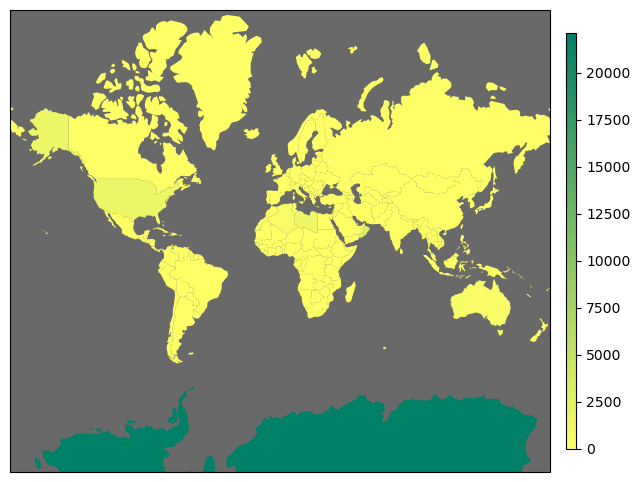

In [10]:
# first choropleth
def plot_world():
    # output projection
    proj = ccrs.Mercator(central_longitude=0)
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': proj})
    
    # re-project geometry to another CRS
    df_proj = countries_count.to_crs(proj.proj4_init)
    
    # add map features
    ax.set_facecolor('dimgray')
    
    # plot geodataframe and include legend (colorbar)
    df_proj.plot(ax=ax, column='meteorite_count', cmap='summer_r', categorical=False,
                 legend=True, legend_kwds={'shrink': 0.9, 'pad': 0.02, 'aspect': 40})
    plt.show()
    
plot_world()

This map shows very clearly that by far the most meteorites have been found in Antarctica. In comparison the numbers for the other countries are much lower, which makes the color contrasts for the rest of the countries very small.

We need to customize the colormap and create patches. Otherwise the choropleth does not display much contrast between the countries. The polygon colors blend with each other and the plot is less readable. We will also generate the next plot without Antarctica. The following country after Antarctica is Oman with 2991 meteorite strikes.

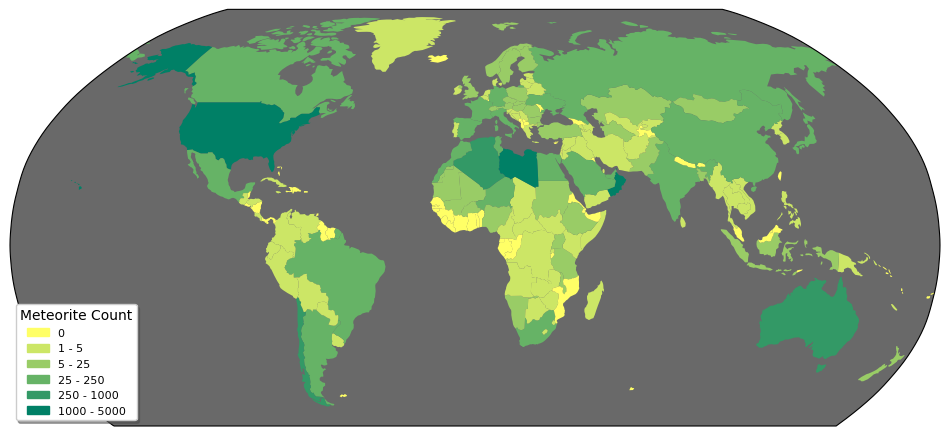

In [11]:
# more customized and fixed plot
def custom_choropleth():
    # output projection
    proj = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': proj})
    
    # new geodataframe without Antarctica
    countries_count_ = countries_count[countries_count['continent'] != 'Antarctica']
    
    # re-project geometry to another CRS
    df_proj = countries_count_.to_crs(proj.proj4_init)
    
    # add map features
    ax.set_facecolor('dimgray')
    
    # plot geodataframe with counts
    df_proj.plot(ax=ax, column='meteorite_count', cmap='summer_r', scheme='user_defined', categorical=False,
                 legend=True, classification_kwds={'bins': [0, 5, 25, 250, 1000, 5000]})
    
    # create legend
    from numpy import arange
    from matplotlib.pyplot import get_cmap
    from matplotlib.patches import Patch
    
    patch_list = []
    label_list = ['0', '1 - 5', '5 - 25', '25 - 250', '250 - 1000', '1000 - 5000']
    cmap = get_cmap('summer_r')
    
    for i, j in zip(label_list, arange(0.0, 1.2, 0.2)):
        patch_list.append(Patch(color=cmap(j), label=i))
        
    plt.legend(handles=patch_list, prop={'size': 8}, loc='lower left', title='Meteorite Count', shadow=True)
    plt.show()
    
custom_choropleth()

### 4. Landings For Czech Republic

At this stage, we will take advantage of geographic datasets to map meteorite distribution in any country, my choice will be Czech Republic in Europe. This time we need more accurate world administrative boundaries, a shapefile with higher resolution. The default country borders in <code>GeoPandas</code> are very generalized.

The shapefile format uses at least three files: SHP, DBF, SHX. All extensions are needed to open the base file properly. Therefore, they are typically zipped in files for further distribution. We will download files from [OpenDataSoft](https://public.opendatasoft.com/explore/dataset/world-administrative-boundaries/export/) into a new directory and open it's content.

In [12]:
# download SHP file from URL (does not work in def() function..)
import requests
import zipfile
import io
import os

url = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/\
exports/shp?lang=en&timezone=Europe%2FBerlin'

# create new folder for files
if not os.path.exists('temp/'):
    os.makedirs('temp/')

try:
    # set URL request and extract to new folder
    req = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(req.content)) as new_zip:
        new_zip.extractall(path='temp/')
        
except:
    print('Some interruption occurred')
else:
    print('Files downloaded\n')

# display downloaded file names
file_names = [y for y in sorted(new_zip.namelist()) for ext in ['.dbf', '.prj', '.shp', '.shx'] if y.endswith(ext)]
print(file_names)

Files downloaded

['world-administrative-boundaries.dbf', 'world-administrative-boundaries.prj', 'world-administrative-boundaries.shp', 'world-administrative-boundaries.shx']


In [13]:
# create new geodataframe for countries
def load_world_2():
    dbf, prj, shp, shx = [file_name for file_name in file_names]
    geodataframe = gpd.read_file('temp/' + shp)
    
    # rename column
    geodataframe.rename(columns={'name': 'country'}, inplace=True)
    
    return geodataframe

gdf_world2 = load_world_2()
gdf_world2.head(3)

,iso3,status,color_code,country,continent,region,iso_3166_1_,french_shor,geometry
0,MNP,US Territory,USA,Northern Mariana Islands,Oceania,Micronesia,MP,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ..."
1,NaN,Sovereignty unsettled,RUS,Kuril Islands,Asia,Eastern Asia,NaN,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ..."
2,FRA,Member State,FRA,France,Europe,Western Europe,FR,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6..."


In [14]:
# check new geodataframe's EPGS - should be in PRJ file
def read_proj():
    dbf, prj, shp, shx = [file_name for file_name in file_names]
    prj_file = open('temp/' + prj, 'r')
    
    # read the individual lines
    f1 = prj_file.readlines()
    for i in f1:
        print(i)
    
read_proj()

GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]]


The new world dataset has the same CRS as meteorites. To investigate the meteorite distribution in Czech Republic, we can plot meteorite points on this area (polygon). We will plot the country shape on a base map and overlay the scatter points.

In [15]:
# make new spatial join: meteorites (gdf) contained in each country (gdf_world2)
gdf_countries =  gpd.sjoin(left_df=gdf_world2, right_df=gdf, how='right', predicate='contains')
gdf_countries.head(3)

,index_left,iso3,status,color_code,country,continent,region,iso_3166_1_,french_shor,name,id,class,mass,fall,year,reclat,reclong,geometry
0,141.0,DEU,Member State,DEU,Germany,Europe,Western Europe,DE,Allemagne,Aachen,1,L5,0.021,Fell,1880,50.77500,6.08333,POINT (6.08333 50.77500)
1,183.0,DNK,Member State,DNK,Denmark,Europe,Northern Europe,DK,Danemark,Aarhus,2,H6,0.720,Fell,1951,56.18333,10.23333,POINT (10.23333 56.18333)
2,75.0,CAN,Member State,CAN,Canada,Americas,Northern America,CA,Canada,Abee,6,EH4,107.000,Fell,1952,54.21667,-113.00000,POINT (-113.00000 54.21667)


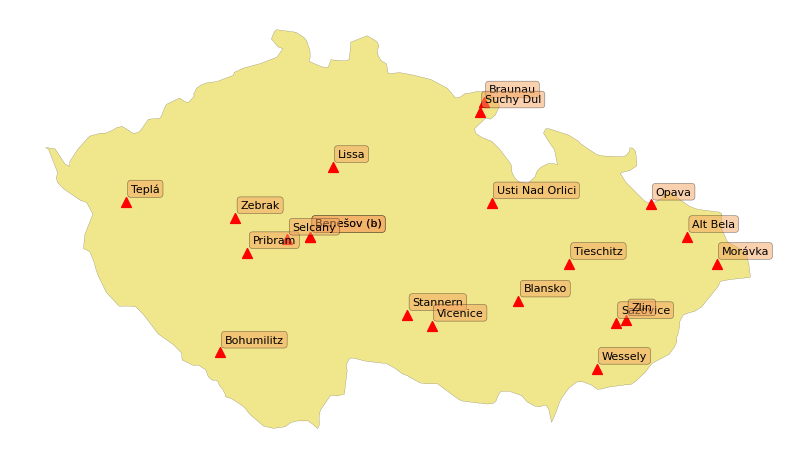

In [16]:
# plot meteorite distribution in Czechia
def czech_distribution():
    # search pattern: this country is called 'Czech Republic' or 'Czechia'
    search_pat = 'Czech'
    # extract meteorites
    czech_points = gdf_countries.loc[gdf_countries['country'].str.startswith(pat=search_pat, na=False)]
    # extract polygon
    czech_polygon = gdf_world2.loc[gdf_world2['country'].str.startswith(pat=search_pat, na=False)]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    
    # define base map and scatter plot
    basemap = czech_polygon.plot(ax=ax, color='khaki', edgecolor='black', linewidth=0.1)
    scatter_plt = czech_points.plot(ax=basemap, marker='^', color='red', markersize=50)
    
    # extract columns to lists
    x = czech_points['reclong'].tolist()
    y = czech_points['reclat'].tolist()
    n = czech_points['name'].tolist()
    
    # dictionaries with text and box properties
    kwargs = {'fontstyle': 'normal', 'color': 'black'}
    bbox_kwargs = {'facecolor': 'sandybrown', 'alpha': 0.5, 'linewidth': 0.4, 'boxstyle': 'round'}
    
    # add meteorite names
    for i, txt in enumerate(n):
        plt.text(x=x[i]+.05, y=y[i]+.06, s=txt, fontsize=8, **kwargs, bbox=bbox_kwargs)
        
    plt.show()

czech_distribution()

The last figure will display the meteorite distribution in Czechia for the 6 most numerous classes.

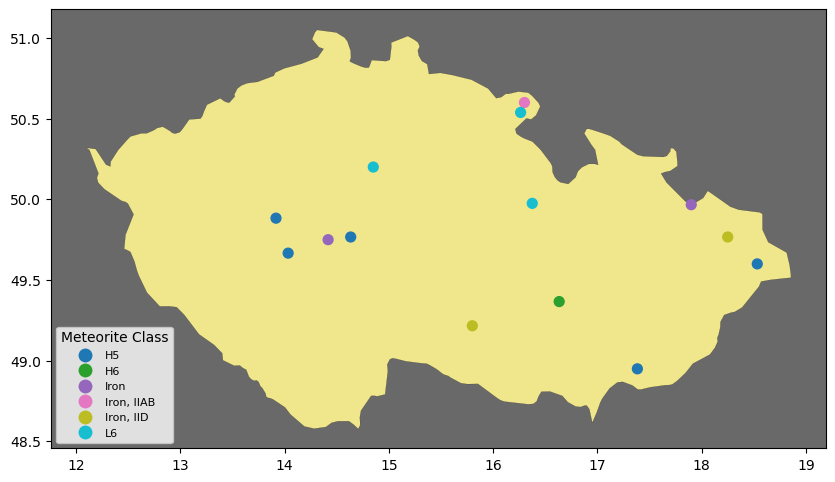

In [17]:
# meteorite class distribution in Czechia
def class_distribution():
    # search pattern: this country is called 'Czech Republic' or 'Czechia'
    search_pat = 'Czech'
    
    global czech_top_6
    # new dataframe with counts for top 6 classes
    czech_points = gdf_countries.loc[gdf_countries['country'].str.startswith(pat=search_pat, na=False)]
    top_6 = czech_points['class'].value_counts().head(6)
    czech_top_6 = czech_points.loc[czech_points['class'].isin(top_6.index.values)]
    
    # extract polygon
    czech_polygon = gdf_world2.loc[gdf_world2['country'].str.startswith(pat=search_pat, na=False)]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_facecolor('dimgray')
    
    # legend properties
    legend_prop = {'loc': 'lower left', 'title': 'Meteorite Class', 'prop': {'size': 8}}
    
    # define base map and scatter plot
    basemap = czech_polygon.plot(ax=ax, color='khaki', edgecolor='black', linewidth=0.1)
    scatter_plt = czech_top_6.plot(ax=basemap, marker='o', column='class', categorical=True, markersize=50,
                                   legend=True, legend_kwds=legend_prop)
    
    plt.show()

class_distribution()

In [18]:
# display top classes in this country and their counts
pd.DataFrame(czech_top_6['class'].value_counts())

,count
class,
H5,5
L6,3
"Iron, IID",2
Iron,2
H6,1
"Iron, IIAB",1


### 5. Conclusions

A visual analysis was made to present geographic distribution of meteorite landings worldwide for each country. Plots were generated with <code>cartopy</code>. The main maps created in this notebook are: a worldwide choropleth of meteorite landings (without Antarctica) and two maps for Czech Republic. First one displays all found meteorites with their names, second shows the distribution of meteorites for top 6 numerous classes.

<code>GeoPandas</code> allows to make working with geospatial data in Python much easier. We can make geospatial operations and basic calculations on vector data. It also has an in-built geographic dataset with countries. Combining this package with <code>cartopy</code> makes mapping more quick, professional, and accurate. Objects on plots are oriented by projection properties and transformations.

### 6. Bonus: Meteorite Landings by Discovery Type

An additional map in this notebook will display worldwide landings by their fall type. We will exclude Antarctica like in previous charts.

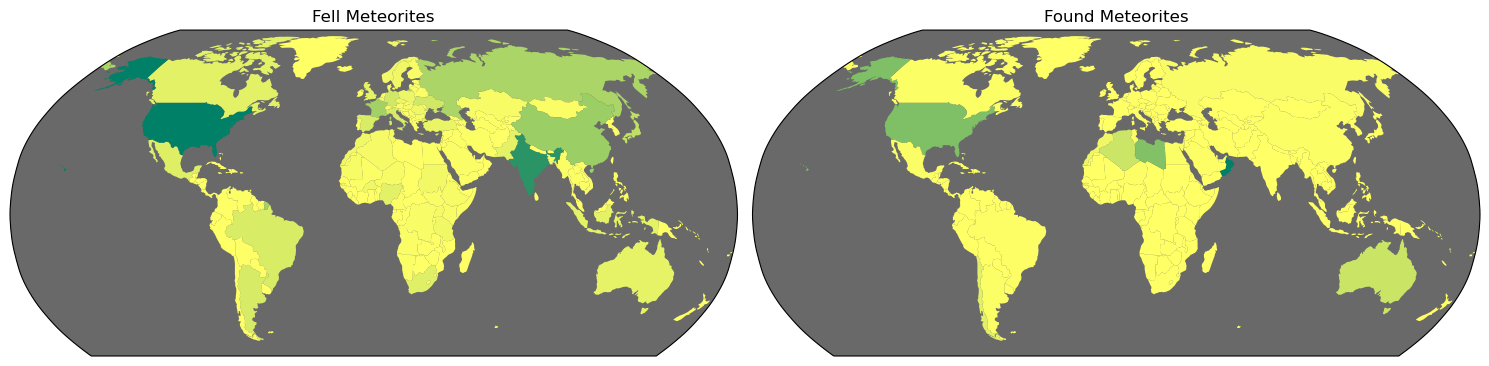

In [19]:
# worldwide point distribution by fell/found
def points_choropleth():
    proj = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': proj}, figsize=(15, 6))
    
    # extract geodataframes by fall type
    gdf_fell = gdf[gdf['fall'] == 'Fell']
    gdf_found = gdf[gdf['fall'] == 'Found']
    
    # exclude Antarctica
    gdf_world_ = gdf_world[gdf_world['continent'] != 'Antarctica']
    
    # new dataframes
    def new_geodataframe(gdf_right):
        gdf_countries = gpd.sjoin(left_df=gdf_world_, right_df=gdf_right, how='right', predicate='contains')
        gdf_count = gdf_countries.groupby('country')[['id']].count().reset_index()
        gdf_count.rename(columns={'id': 'meteorite_count'}, inplace=True)
        countries_count = pd.merge(left=gdf_world_, right=gdf_count, on='country', how='left')
        countries_count.fillna(value=0, inplace=True)
        return countries_count
    
    countries_count1 = new_geodataframe(gdf_right=gdf_fell)
    countries_count2 = new_geodataframe(gdf_right=gdf_found)
    
    # re-project geometry to another CRS
    df_proj1 = countries_count1.to_crs(proj.proj4_init)
    df_proj2 = countries_count2.to_crs(proj.proj4_init)
    
    # define lists
    proj_list = [df_proj1, df_proj2]
    title_list = ['Fell Meteorites', 'Found Meteorites']
    
    # generate plots
    for i, (proj, title) in enumerate(zip(proj_list, title_list)):
        proj.plot(ax=ax[i], column='meteorite_count', cmap='summer_r', categorical=False)
        ax[i].set_title(title)
        ax[i].set_facecolor('dimgray')
    
    plt.tight_layout()
    plt.show()
    
points_choropleth()